In [1]:
import numpy as np
import matplotlib 
import matplotlib as mpl

import halophot
from halophot.halo_tools import halo_tpf
import lightkurve as lk
from astropy.table import Table

%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(10.0,10.0)    #(6.0,4.0)
matplotlib.rcParams['font.size']=16              #10 
matplotlib.rcParams['savefig.dpi']= 300             #72 
colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']


Populating the interactive namespace from numpy and matplotlib


In [2]:
ls ../data/

ktwo200128910-c111_lpd-targ.fits.gz  ktwo205897543-c03_lpd-targ.fits.gz
ktwo200173843-c13_lpd-targ.fits.gz


In [3]:
fname = "../data/ktwo200173843-c13_lpd-targ.fits.gz" # aldebaran


In [4]:
tpf = halo_tpf(fname)

<AxesSubplot:title={'center':'Target ID: 200173843, Cadence: 140879'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

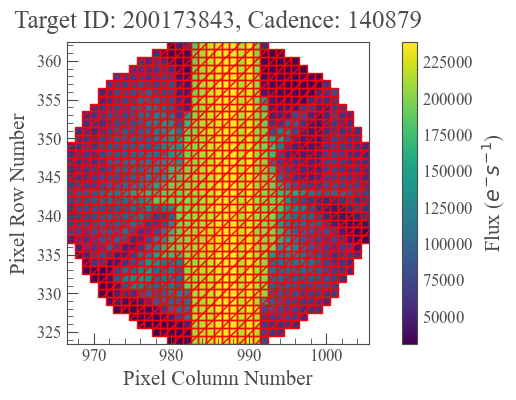

In [5]:
tpf.plot(frame=1,aperture_mask=tpf.pipeline_mask)

In [6]:
lc = tpf.to_lightcurve()
lc.primary_header = tpf.hdu[0].header
lc.data_header = tpf.hdu[1].header


<ipython-input-6-39f5cb9c0aea>:2: UserWarning: Lightkurve doesn't allow columns or meta values to be created via a new attribute name.A new attribute is created. It will not be carried over when the object is copied. - see https://docs.lightkurve.org/reference/api/lightkurve.LightCurve.html
  lc.primary_header = tpf.hdu[0].header
<ipython-input-6-39f5cb9c0aea>:3: UserWarning: Lightkurve doesn't allow columns or meta values to be created via a new attribute name.A new attribute is created. It will not be carried over when the object is copied. - see https://docs.lightkurve.org/reference/api/lightkurve.LightCurve.html
  lc.data_header = tpf.hdu[1].header


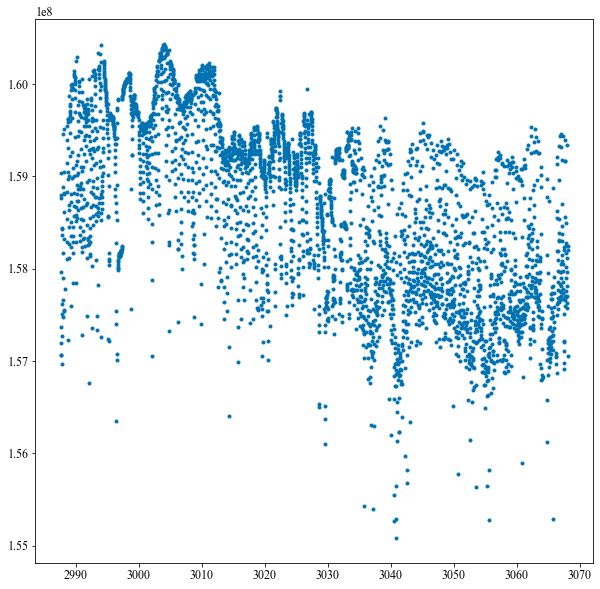

In [7]:
plt.plot(lc.time.value, lc.flux,'.')


In [8]:
from astropy.time import Time

In [9]:
Time(tpf.time.value,format=tpf.time.format)

<Time object: scale='utc' format='bkjd' value=[2987.58119824 2987.60163055 2987.62206266 ... 3068.10269758 3068.12312938
 3068.14356137]>

## Now to do Halophot


In [10]:
tpf = halo_tpf(fname)

In [11]:
tpf.flux.unit

Unit("electron / s")

In [12]:
print(halophot.__version__)

0.7.4.2


In [13]:
%%time
meta, corr_lc = tpf.halo(split_times=[3010],thresh=0.5);
weightmap = meta['weightmap'][0]

Taking cadences from beginning to 1027
585 saturated pixels
Throwing out 2 bad cadences
Censored TPF
Subsampling by a factor of 1
Calculating weights
Using Analytic Derivatives
Calculated weights!
Taking cadences from 1027 to end
595 saturated pixels
Throwing out 1 bad cadences
Censored TPF
Subsampling by a factor of 1
Calculating weights
Using Analytic Derivatives
Calculated weights!
CPU times: user 9.2 s, sys: 1.98 s, total: 11.2 s
Wall time: 3.73 s


/Users/benjaminpope/opt/anaconda3/lib/python3.8/site-packages/halophot-0.7.4.2-py3.8.egg/halophot/halo_tools.py:1141: UserWarning: Lightkurve doesn't allow columns or meta values to be created via a new attribute name.A new attribute is created. It will not be carried over when the object is copied. - see https://docs.lightkurve.org/reference/api/lightkurve.LightCurve.html
/Users/benjaminpope/opt/anaconda3/lib/python3.8/site-packages/halophot-0.7.4.2-py3.8.egg/halophot/halo_tools.py:1142: UserWarning: Lightkurve doesn't allow columns or meta values to be created via a new attribute name.A new attribute is created. It will not be carried over when the object is copied. - see https://docs.lightkurve.org/reference/api/lightkurve.LightCurve.html
/Users/benjaminpope/opt/anaconda3/lib/python3.8/site-packages/halophot-0.7.4.2-py3.8.egg/halophot/halo_tools.py:1143: UserWarning: Lightkurve doesn't allow columns or meta values to be created via a new attribute name.A new attribute is created. It

In [14]:
corr_lc.flux

<Quantity [0.9941961 , 0.9942248 , 0.9943257 , ..., 0.9989854 , 0.99870145,
           0.99875045]>

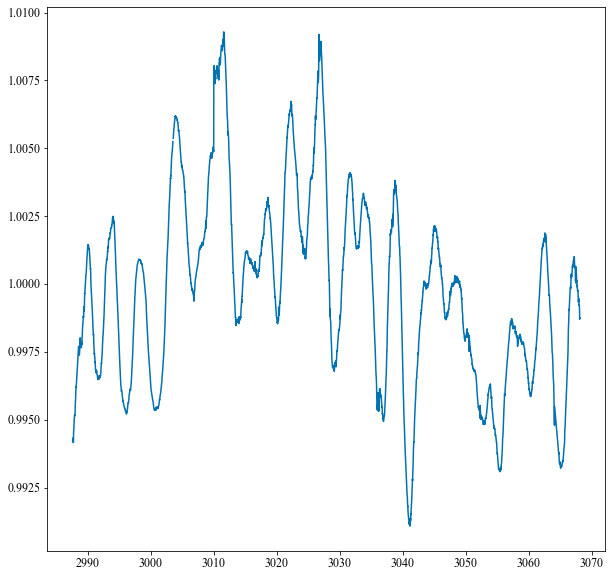

In [15]:
plt.plot(corr_lc.time.value,corr_lc.flux)

<ipython-input-16-a8a40146cfc1>:3: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("seismic"))
  cmap.set_bad('k',1.)


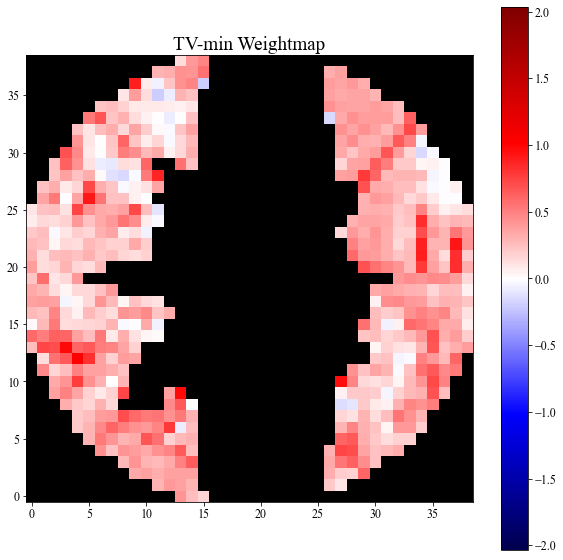

In [16]:
cmap = mpl.cm.seismic
norm = np.size(weightmap)
cmap.set_bad('k',1.)
im = np.log10(weightmap.T*norm)
plt.imshow(im,cmap=cmap, vmin=-2*np.nanmax(im),vmax=2*np.nanmax(im),
    interpolation='None',origin='lower')
plt.colorbar()
plt.title('TV-min Weightmap')
plt.savefig('aldebaran_weightmap.png')

In [17]:
from astropy.io import fits

In [18]:
f = fits.PrimaryHDU(weightmap)

In [19]:
f.writeto('aldebaran_weightmap.fits',overwrite=True)

### Now let's try and correct it with k2sc

In [20]:
import k2sc
from k2sc import standalone

corr_lc.__class__ = standalone.k2sc_lc

In [21]:
corr_lc.k2sc()

/Users/benjaminpope/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
plt.plot(corr_lc.time,corr_lc.flux,'.',label="Uncorrected")
plt.plot(corr_lc.time,corr_lc.corr_flux,'.',label="K2SC")
plt.legend()
plt.xlabel('BJD')
plt.ylabel('Flux')
plt.title('Aldebaran',y=1.01)